In [27]:
import pickle
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns

import scipy

In [28]:
# generate binary input vector
def simulate_single_input(time, Dv):
    inputs = np.zeros((time, Dv))    
    return inputs

In [29]:
def simulate_clv_with_inputs(A, Wa, g, Wg, f_cov, N, inputs):
    latent_dim = A.shape[0]
    ndays, input_dim = inputs.shape
    x = []
    y_count = []
    y_percentage = []

    # modify the mu
    mu = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=np.eye(latent_dim))
    for t in range(ndays):
        xt = mu

        # increase dimension by 1
        xt1 = np.concatenate((xt, np.array([0])))
        pt = np.exp(xt1 - logsumexp(xt1))

        # simulate total number of reads with over-dispersion
        logN = np.random.normal(loc=np.log(N), scale=0.5)
        Nt = np.random.poisson(np.exp(logN))
        
        yt_count = np.random.multinomial(Nt, pt).astype(float)
        yt_percentage = yt_count / np.sum(yt_count)
        
        x.append(xt)
        y_count.append(yt_count)
        y_percentage.append(yt_percentage)
        
        transition_noise = np.random.multivariate_normal(mean=np.zeros(latent_dim), cov=np.diag(f_cov))
        vt = inputs[t]

        # Wg: (Dx, Dv), Wa: (Dx, Dv)
        mu = xt + g + Wg.dot(vt) + (A + Wa.dot(vt)[:,None]).dot(pt) + transition_noise
        mu = np.clip(mu, -5, 5)

    return np.array(x), np.array(y_count), np.array(y_percentage)

In [30]:
ntaxa = 11
ninput = 0  # including surgery
n_train, n_test = 1800, 30
time_min = 30
time_max = 50
scale = 1
simulation_time = time_max * scale

A  = np.random.normal(loc=0,    scale=0.05, size=(ntaxa - 1, ntaxa))
g  = np.random.normal(loc=0,    scale=0.05, size=(ntaxa - 1,))
Wa = np.random.normal(loc=0,    scale=0.0, size=(ntaxa - 1, ninput))
Wg = np.random.normal(loc=-0.2, scale=0.2, size=(ntaxa - 1, ninput))
f_cov = np.random.uniform(0, 1, ntaxa - 1)
N = 10000 # sequencing reads parameter

In [31]:
overwrite_params = True
if overwrite_params:
    with open("data_no_input/clv_count_ntrain_600_Dx_10.p", "rb") as f:
        d = pickle.load(f)
    A = d["A"]
    Wa = d["Wa"]
    Wg = d["Wg"]
    g = d["g"]
    f_cov = d["f_cov"]
    N = d["N"]

In [32]:
# create data with missing observation
x_train = []
x_test = []
y_count_train = []
y_count_test = []
y_percentage_train = []
y_percentage_test = []
v_train = []
v_test = []

batch_inputs = [simulate_single_input(simulation_time, ninput) for _ in range(n_train + n_test)]

for i in range(n_train + n_test):
    v = batch_inputs[i]
    x, y_count, y_percentage = simulate_clv_with_inputs(A, Wa, g, Wg, f_cov, N, v)

    idx = np.arange(time_max) * scale
    ndays = np.random.randint(time_min, time_max)
    start = np.random.randint(time_max - ndays)
    idx = idx[start:start + ndays]
    
    x = x[idx]
    y_count = y_count[idx]
    y_percentage = y_percentage[idx]
    v = v[idx]
    
    # make missing observations, the first day cannot be missing
    obs_percentage = np.random.choice([0.4,0.5,0.6,0.7,0.8], p=[0.1, 0.2, 0.2, 0.2, 0.3])
    # obs_percentage = 0.999
    obsed_days = np.random.choice(np.arange(1, ndays), int(ndays * obs_percentage), replace=False)
    obsed_days = np.sort(np.concatenate(([0],obsed_days)))
    
    y_percentage = y_percentage[obsed_days]
    x = x[obsed_days]
    y_count = y_count[obsed_days]
    
    days = np.arange(ndays)[:, np.newaxis]
    y_count = np.concatenate([days[obsed_days], y_count], axis=-1)
    y_percentage = np.concatenate([days[obsed_days], y_percentage], axis=-1)
    v = np.concatenate([days, v], axis=-1)
    
    if i < n_train:
        x_train.append(x)
        y_count_train.append(y_count)
        y_percentage_train.append(y_percentage)
        v_train.append(v)
    else:
        x_test.append(x)
        y_count_test.append(y_count)
        y_percentage_test.append(y_percentage)
        v_test.append(v)

In [33]:
counts_train = []
for single_obs in y_count_train:
    single_counts = single_obs[:,1:].sum(axis=-1)
    counts_train.append(single_counts)
    
counts_test = []
for single_obs in y_count_test:
    single_counts = single_obs[:,1:].sum(axis=-1)
    counts_test.append(single_counts)

In [34]:
p_data = {}
p_data["Xtrain"] = x_train
p_data["Xtest"] = x_test
p_data["Ytrain"] = y_percentage_train
p_data["Ytest"] = y_percentage_test
p_data["Vtrain"] = v_train
p_data["Vtest"] = v_test

p_data["A"] = A
p_data["Wa"] = Wa
p_data["g"] = g
p_data["Wg"] = Wg
p_data["f_cov"] = f_cov
p_data["N"] = N
with open("data_no_input/clv_ntrain_{}_Dx_{}.p".format(n_train, ntaxa - 1), "wb") as f:
    pickle.dump(p_data, f)

In [35]:
c_data = {}
c_data["Xtrain"] = x_train
c_data["Xtest"] = x_test
c_data["Ytrain"] = y_count_train
c_data["Ytest"] = y_count_test
c_data["Vtrain"] = v_train
c_data["Vtest"] = v_test
c_data["counts_train"] = counts_train
c_data["counts_test"] = counts_test

c_data["A"] = A
c_data["Wa"] = Wa
c_data["g"] = g
c_data["Wg"] = Wg
c_data["f_cov"] = f_cov
c_data["N"] = N
with open("data_no_input/clv_count_ntrain_{}_Dx_{}.p".format(n_train, ntaxa - 1), "wb") as f:
    pickle.dump(c_data, f)

# visualize the data

In [36]:
import sys
sys.path.append("../..")

In [37]:
from src.utils.data_interpolation import interpolate_data

In [38]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test = x_train, x_test, y_percentage_train, y_percentage_test, v_train, v_test

In [39]:
extra_inputs_train = [None for _ in range(len(obs_train))]
extra_inputs_test = [None for _ in range(len(obs_test))]

In [40]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, _mask_train, _mask_test, time_interval_train, time_interval_test, extra_inputs_train, extra_input_test = \
                interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test,
                                 extra_inputs_train, extra_inputs_test, False)


masks = _mask_train + _mask_test
obs = obs_train + obs_test
inputs = input_train + input_test

In [41]:
# count data
c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test, c_extra_inputs_train, c_extra_inputs_test = x_train, x_test, y_count_train, y_count_test, v_train, v_test, counts_train, counts_test

In [42]:
c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test, c_mask_train, c_mask_test, time_interval_train, time_interval_test, c_extra_inputs_train, c_extra_input_test = \
                interpolate_data(c_hidden_train, c_hidden_test, c_obs_train, c_obs_test, c_input_train, c_input_test,
                                 c_extra_inputs_train, c_extra_inputs_test, False)


c_masks = c_mask_train + c_mask_test
c_obs = c_obs_train + c_obs_test
c_inputs = c_input_train + c_input_test

In [43]:
def bar_plot(ax, obs, mask, to_normalize=True):
    if to_normalize:
            obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    

def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()

In [44]:
def plot_inputs_and_obs(inputs, masks, i, to_normalize=True):
    plt.figure(figsize=(15,10))

    ax1= plt.subplot(2,1,1)
    input_plot(ax1, inputs[i])
    ax1.grid()

    ax2 = plt.subplot(2,1,2, sharex = ax1)
    bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
    ax2.grid()

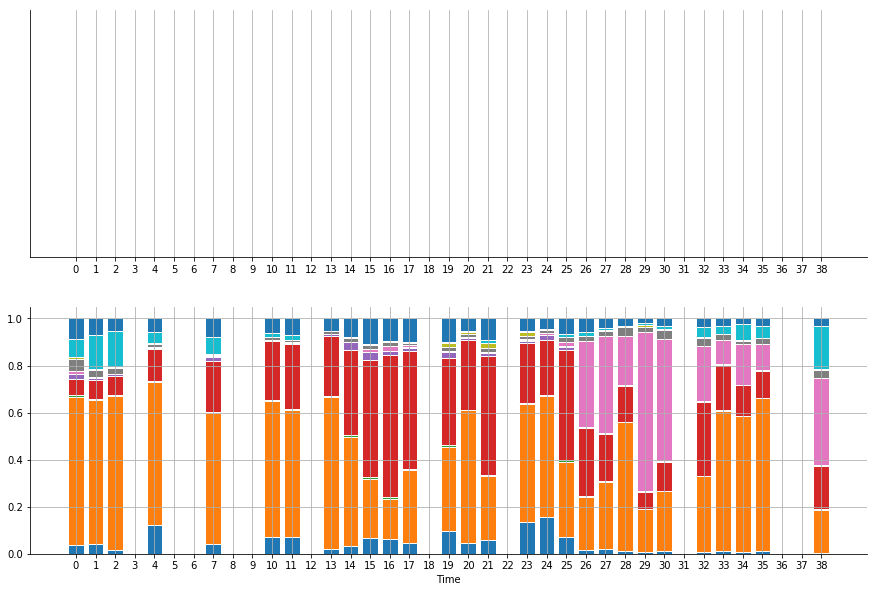

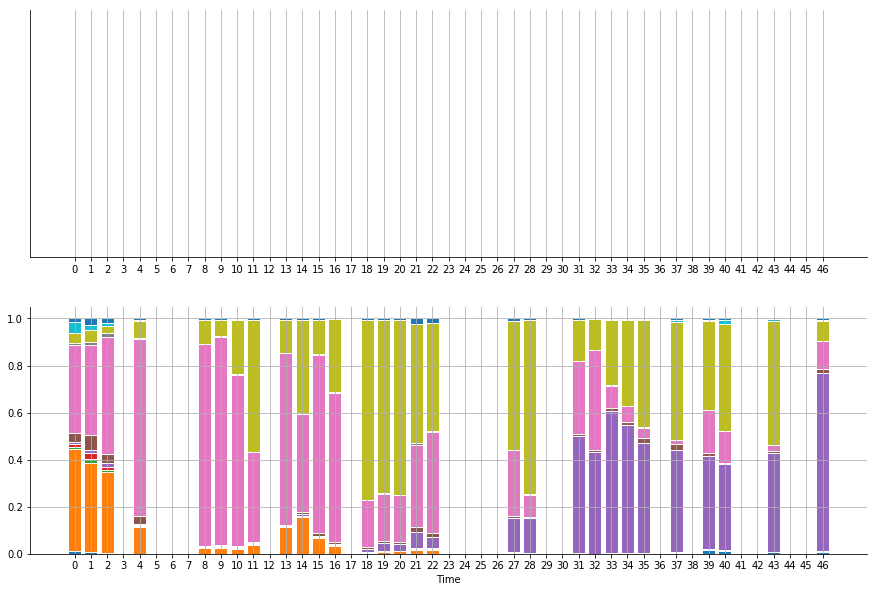

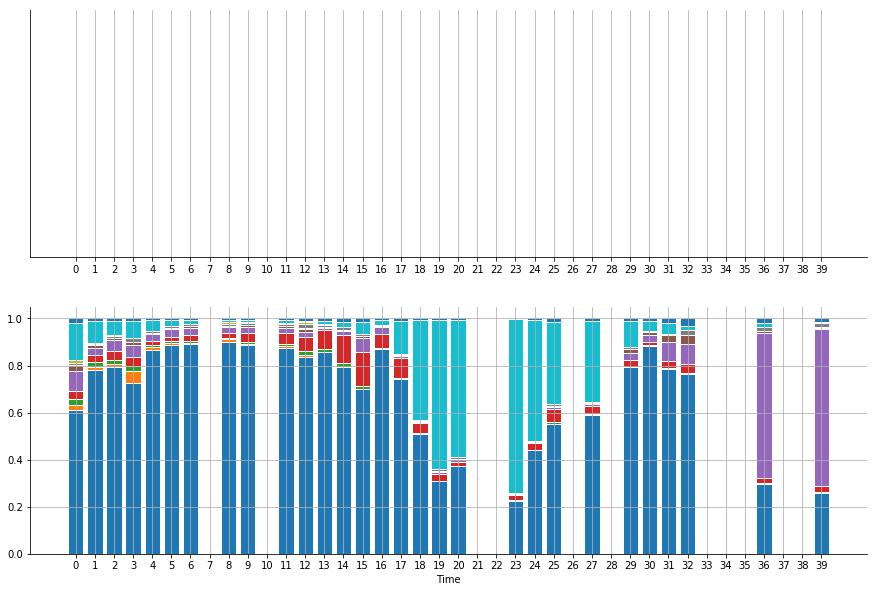

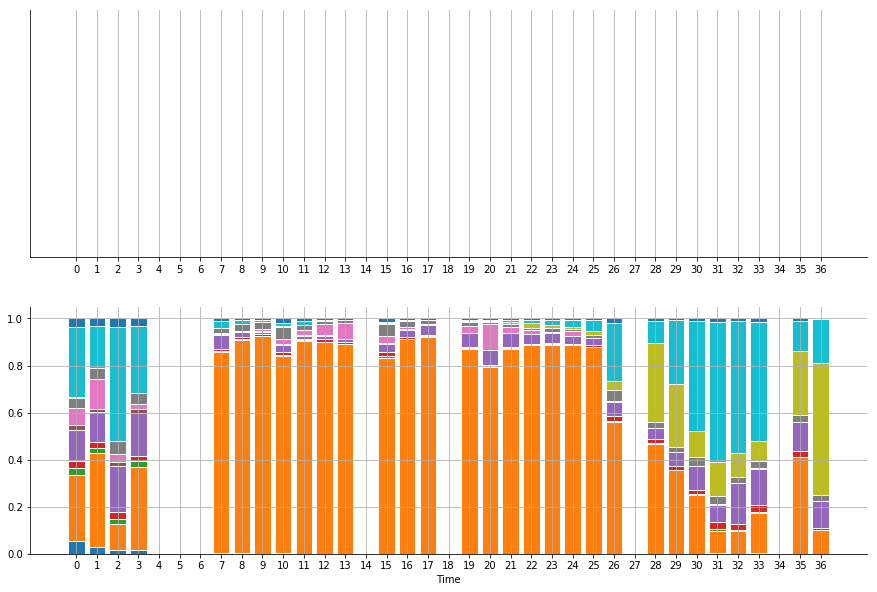

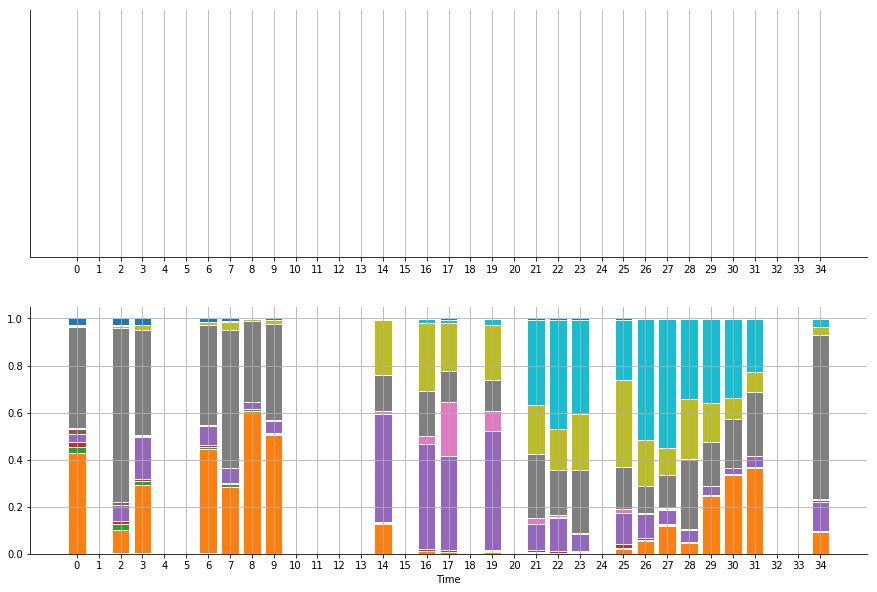

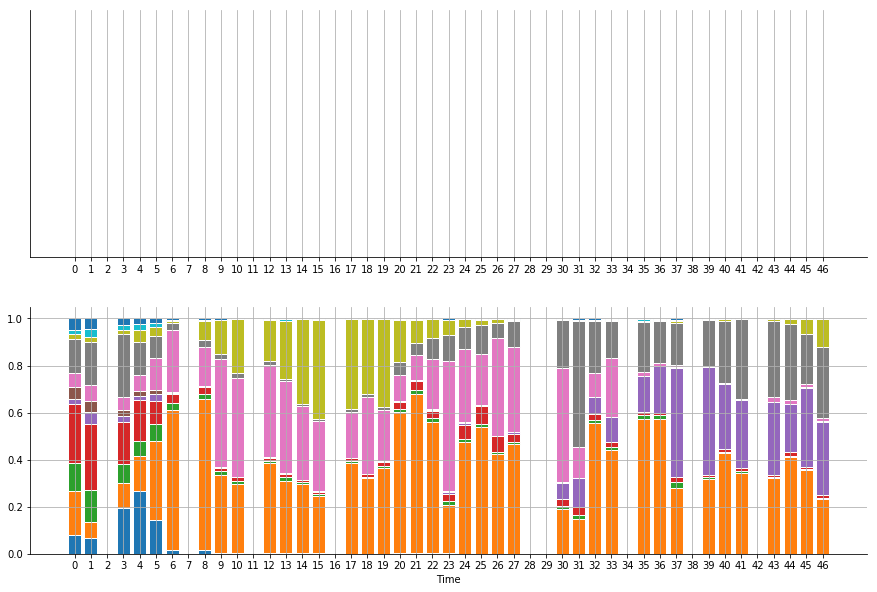

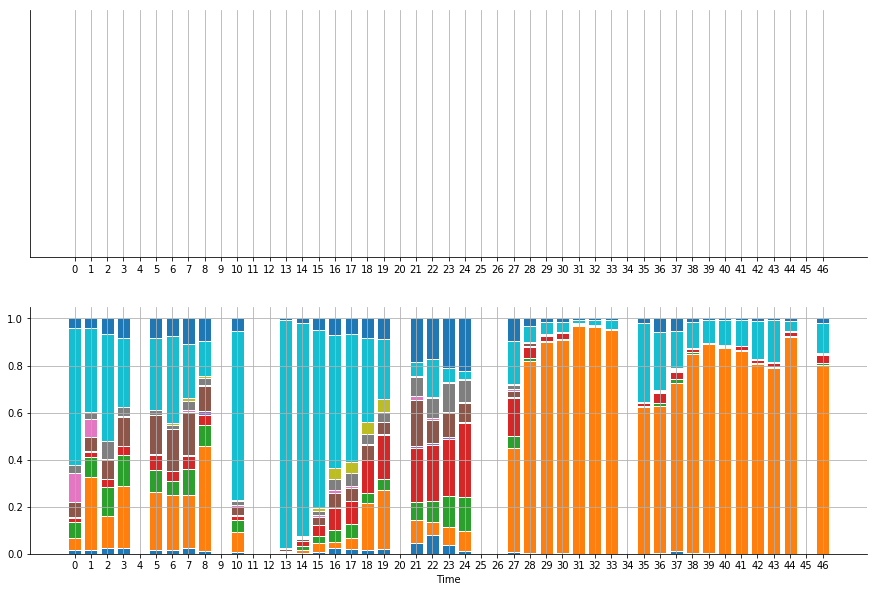

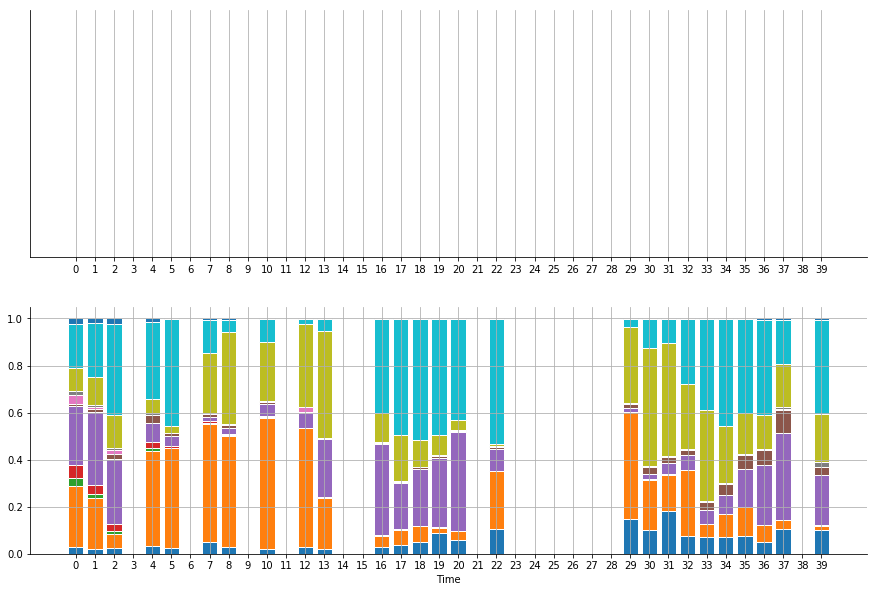

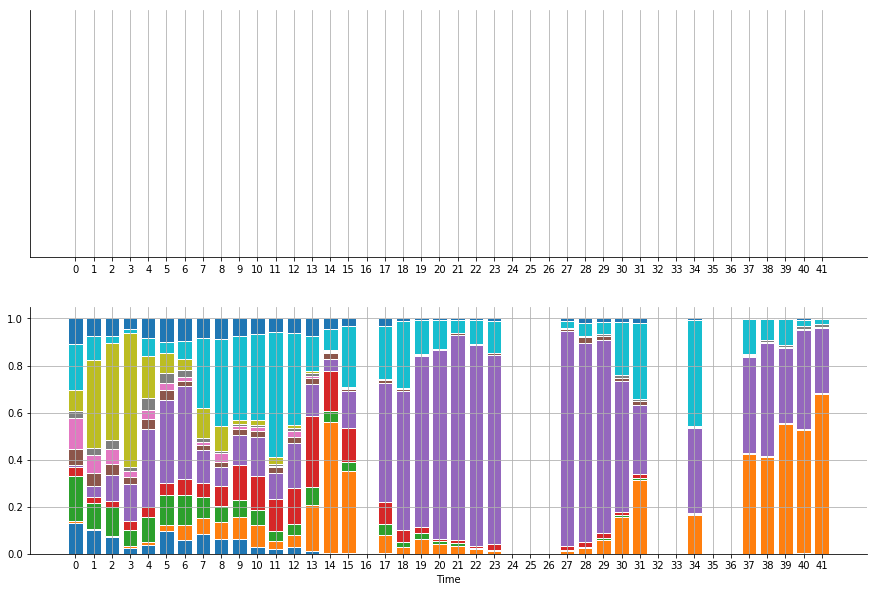

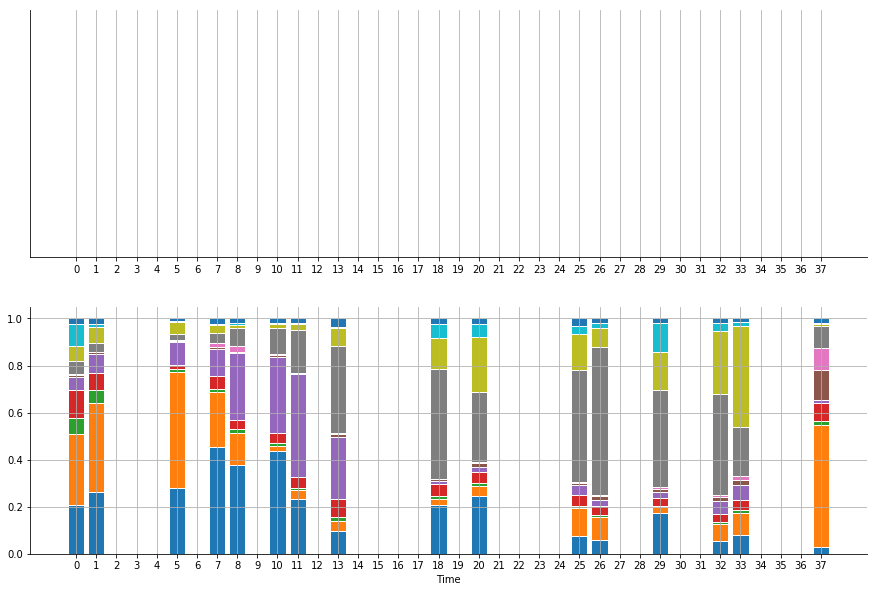

In [45]:
for i in range(10):
    plot_inputs_and_obs(inputs, masks, i)

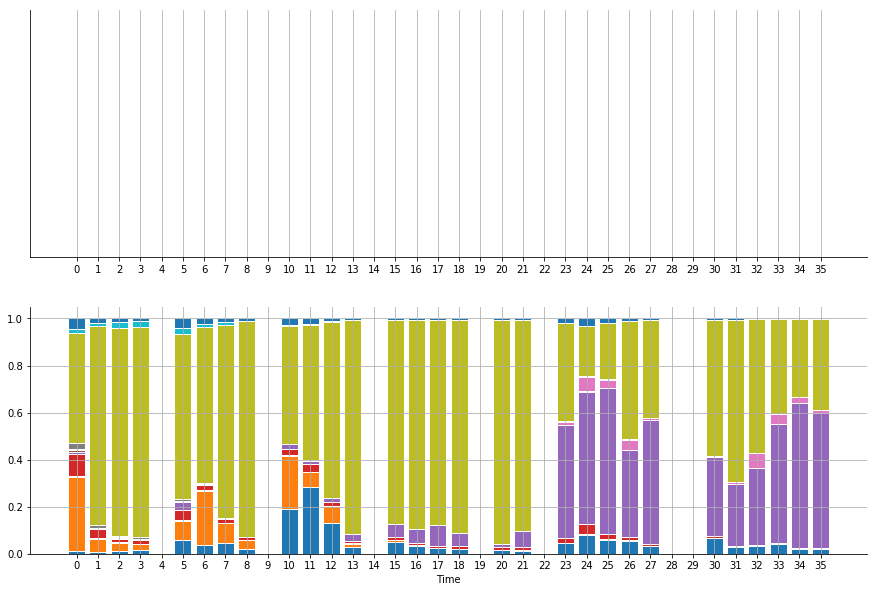

In [46]:
plot_inputs_and_obs(c_inputs, c_masks, 10, to_normalize=True)